# Análise dos Descritores de Cor

Esse notebook tem como objetivo fazer uma checagem de como os descritores de cor implementados funcionam em diferentes Espaços de Cor. Aqui, utilizaremos O <b>Histograma de Cor</b>, o <b> Espectro HSL para Detecção de Olhos Vermelhos</b> e os <b>Descritores de Cor Dominante</b>.

##### Importação das bibliotecas necessárias

In [1]:
import numpy as np
import cv2

from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

Utilizaremos uma imagem de reflexo vermelho diagnósticada como <i>"Normal"</i> para realizar as análises.

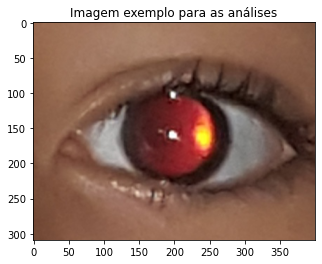

In [2]:
N_I   = "./data/olhos/normal/20170310_095731_0.jpg"

# Ler imagem
image = cv2.imread(N_I)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.title('Imagem exemplo para as análises')
plt.show()

## Primeiro campo de análise: Histogramas de Cor
<hr>
Análise dos Histogramas de Cor para os seguintes Espectros de Cor:
<ul>
    <li>RGB</li>
    <li>HSV</li>
    <li>LAB</li>
</ul>

In [74]:
# Função para plotar gráficos do Histograma
def mostrarGraficos(image, ch_1, ch_2, ch_3):
    f, axarr = plt.subplots(1,2, figsize=(16,4))
    
    axarr[0].imshow(image)
    axarr[1].plot(ch_1, label='CH_1', color='red')
    axarr[1].plot(ch_2, label='CH_2', color='green')
    axarr[1].plot(ch_3, label='CH_3', color='blue')
    axarr[1].legend(loc = 'best')

In [68]:
# Recebe imagem, calcula o hisotgrama de cada canal e plota
def histogramadeCor(image):
    hist = []
    # Calcular Histograma de cor para cada canal da imagem
    ch_1 = cv2.calcHist([image], [0], None, [256], [0, 256])
    ch_2 = cv2.calcHist([image], [1], None, [256], [0, 256])
    ch_3 = cv2.calcHist([image], [2], None, [256], [0, 256])
    # Mostrar histograma pra cada canal
    mostrarGraficos(image, ch_1, ch_2, ch_3)

### RGB (Red, Green, Blue)

In [75]:
# Mostrar as variáveis referentes a imagem nos 3 canais
image_rgb = image
image_rgb[0][0]

array([153, 106,  80], dtype=uint8)

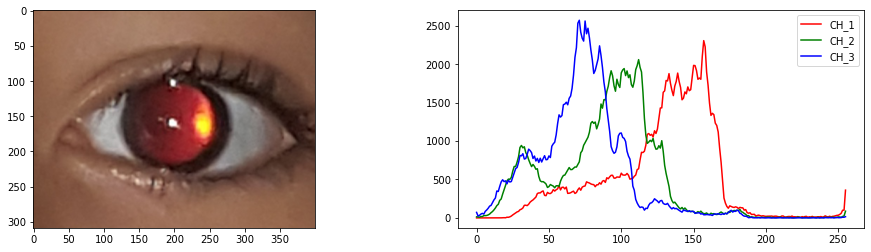

In [76]:
histogramadeCor(image_rgb)

### HSV (Hue, Saturation, Value)

In [7]:
image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
image_hsv[0][0]

array([ 11, 122, 153], dtype=uint8)

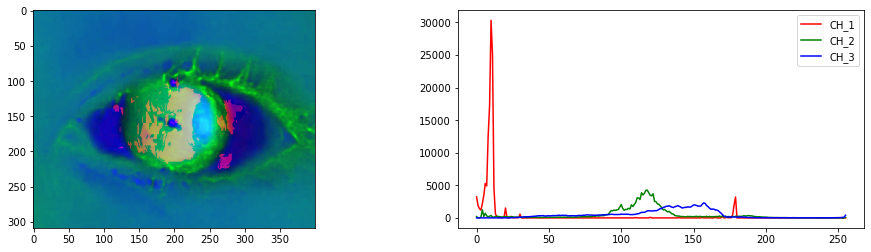

In [77]:
histogramadeCor(image_hsv)

### Lab

In [10]:
image_lab = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)
image_lab[0][0]

array([125, 144, 150], dtype=uint8)

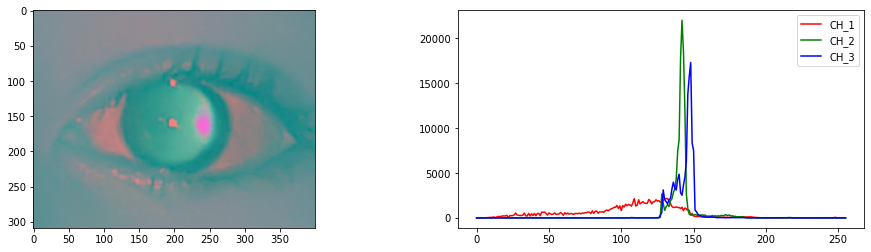

In [78]:
histogramadeCor(image_lab)

## Segundo Campo de Análise: HSL com Detecção de Olhos Vermelhos

<hr>
Análise da utilização do HSL com Detecção de Olhos Vermelhos para os seguintes Espectros de Cor:
<ul>
    <li>RGB</li>
</ul>
<b>Só funciona no espectro RGB!</b>

In [13]:
# Recebe uma image, converge para HSL, faz um cálculo e retorna somente
# A parte mais avermelhada da imagem
def hslOlhosVermelhos(img):
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    H        = hls[:, :, 0]
    L        = hls[:, :, 1]
    S        = hls[:, :, 2]
    LS_ratio = L/(S + 1e-6)

    # Otimizar?
    redeye = ((L >= 64) * (S >= 100) * np.logical_or(H <= 7, H >= 162) *
              (LS_ratio > 0.5) * (LS_ratio < 1.5)).astype(bool)
    
    redeye = cv2.cvtColor(redeye.astype(np.uint8)*255, cv2.COLOR_GRAY2RGB)
    
    redeye_only = img.copy();
    redeye_only[np.where(np.logical_not(redeye))] = 255
    
    return redeye_only

### RGB (Red, Green, Blue)

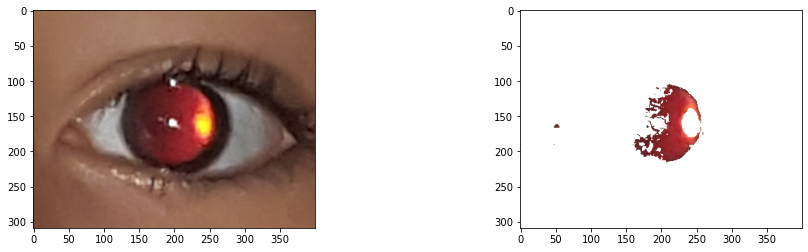

In [82]:
image_OV = hslOlhosVermelhos(image_rgb)

f, axarr = plt.subplots(1,2, figsize=(16,4))
axarr[0].imshow(image)
axarr[1].imshow(image_OV)

## Segundo campo de análise: Descritores de Cor Dominante

<hr>
Análise dos Descritores de Cor Dominante para os seguintes Espectros de Cor:
<ul>
    <li>RGB</li>
    <li>HSV</li>
    <li>LAB</li>
</ul>

In [88]:
def find_histogram(clt):

    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins=numLabels)

    hist = hist.astype("float")
    hist /= hist.sum()

    return hist

def plot_colors2(hist, centroids):
    
    bar = np.zeros((50, 300, 3), dtype="uint8")
    startX = 0

    for (percent, color) in zip(hist, centroids):
        # plotar o percentual de cada cluster na imagem
        endX = startX + (percent * 300)
        cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),
                      color.astype("uint8").tolist(), -1)
        startX = endX

    # retorna o grafico em barra
    return bar

def corDominante(img):

    img = img.reshape((img.shape[0] * img.shape[1],3)) #represent as row*column,channel number
    clt = KMeans(n_clusters = 4) #cluster number
    clt.fit(img)

    hist = find_histogram(clt)
    bar = plot_colors2(hist, clt.cluster_centers_)
    
    return bar

### RGB (Red, Green, Blue)

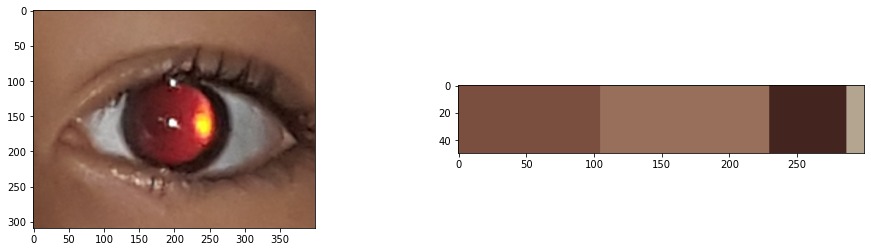

In [89]:
bar_rgb = corDominante(image_rgb)

f, axarr = plt.subplots(1,2, figsize=(16,4))
axarr[0].imshow(image_rgb)
axarr[1].imshow(bar_rgb)

#### OBS: TONALIDADE DA PELE AFETA BASTANTE NO VETOR FINAL

### HSV (Hue, Saturation, Value)

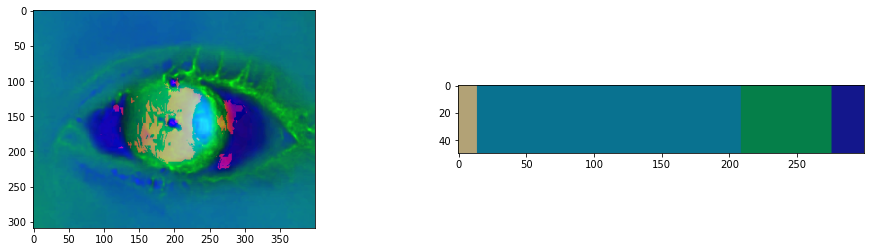

In [90]:
bar_hsv = corDominante(image_hsv)

f, axarr = plt.subplots(1,2, figsize=(16,4))
axarr[0].imshow(image_hsv)
axarr[1].imshow(bar_hsv)

### LAB

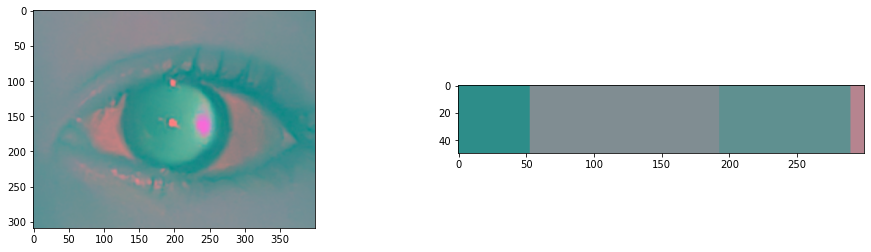

In [91]:
bar_lab = corDominante(image_lab)

f, axarr = plt.subplots(1,2, figsize=(16,4))
axarr[0].imshow(image_lab)
axarr[1].imshow(bar_lab)